# **Taller 1**

## Librerias a importar


In [199]:
#Librerias
!pip install wordcloud
!pip install numpy matplotlib scikit-learn
!pip install sklearn
!pip install matplotlib
!pip install python-Levenshtein
!pip install -U spacy
!python -m spacy download es_core_news_sm
!pip install pyspellchecker==0.7.2
import string
import matplotlib.pyplot as plt
import random
import os
import math
import re
import nltk
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spellchecker
import Levenshtein
import glob
from wordcloud import WordCloud
from functools import reduce
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.metrics import BigramAssocMeasures
from nltk import BigramAssocMeasures
from nltk.collocations import BigramCollocationFinder
from collections import Counter
from spellchecker import SpellChecker
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

#Funciones
nlp = spacy.load('es_core_news_sm')


2023-06-18 22:10:33.224359: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 5.1 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


[nltk_data] Downloading package stopwords to /home/diego/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/diego/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/diego/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Cargar texto

In [290]:
#Cargamos el texto
mitexto=open("./Data/cien_anos_soledad.txt", "r")
contenido= mitexto.read()
mitexto.close()

## Punto 1

Lo primero que se va hacer es normalizar el texto en minusculas y eliminar algunos elementos que vienen por defecto en el texto.

In [262]:
contenido_lower= contenido.lower()
print(contenido_lower)
type(contenido_lower)

capitulo 1

muchos años después, frente al pelotón de fusilamiento, el coronel aureliano buendía había de 
recordar aquella tarde remota en que su padre lo llevó a conocer el hielo. macondo era entonces 
una aldea de veinte casas de barro y cañabrava construidas a la orilla de un río de aguas diáfanas 
que se precipitaban por un lecho de piedras pulidas, blancas y enormes como huevos 
prehistóricos. el mundo era tan reciente, que muchas cosas carecían de nombre, y para 
mencionarlas había que señalarías con el dedo. todos los años, por el mes de marzo, una familia 
de gitanos desarrapados plantaba su carpa cerca de la aldea, y con un grande alboroto de pitos y 
timbales daban a conocer los nuevos inventos. primero llevaron el imán. un gitano corpulento, de 
barba montaraz y manos de gorrión, que se presentó con el nombre de melquíades, hizo una 
truculenta demostración pública de lo que él mismo llamaba la octava maravilla de los sabios 
alquimistas de macedonia. fue de casa en casa ar

str

## Punto 2

Segmente sus documentos a nivel de frase (considere separadores de frase puntos, comas, puntos y comas).Guarde ese resultado en un archivo frases.txt.

In [203]:
# Modelo para separacion por frases

class SeparadorFrases(object):
    def __init__(self):
        self.separation_scheme = r'(?<=[.,;:¿?¡!-"])\s+'
        self.puntuacion = '—-.,;:¡!¿?""'

    def separar(self, texto):
        return re.split(self.separation_scheme, texto.lower())

    #Se crea una funcion para eleminar la puntuacion de frases o de texto, luego de ser separadas.
    def quitar_puntuacion(self, frase):
        # Crea una tabla de traducción para eliminar los caracteres de puntuación
        tabla = str.maketrans('', '', self.puntuacion)
        # Aplica la traducción a la frase y retorna la frase sin los caracteres de puntuación
        return frase.translate(tabla)
    
    def separar_y_quitar_puntuacion(self, texto):
        return [self.quitar_puntuacion(frase) for frase in self.separar(texto)]
    
    

In [204]:
frases_terminadas = SeparadorFrases().separar_y_quitar_puntuacion(contenido)
print(frases_terminadas)

#Procedemos a guardar el resultado en un txt
archivo_salida = open("./Data/frases.txt", "w")
for frase_terminada in frases_terminadas:
    archivo_salida.write(frase_terminada + "\n")
archivo_salida.close()


['muchos años después', 'frente al pelotón de fusilamiento', 'el coronel aureliano buendía había de \nrecordar aquella tarde remota en que su padre lo llevó a conocer el hielo', 'macondo era entonces \nuna aldea de veinte casas de barro y cañabrava construidas a la orilla de un río de aguas diáfanas \nque se precipitaban por un lecho de piedras pulidas', 'blancas y enormes como huevos \nprehistóricos', 'el mundo era tan reciente', 'que muchas cosas carecían de nombre', 'y para \nmencionarlas había que señalarías con el dedo', 'todos los años', 'por el mes de marzo', 'una familia \nde gitanos desarrapados plantaba su carpa cerca de la aldea', 'y con un grande alboroto de pitos y \ntimbales daban a conocer los nuevos inventos', 'primero llevaron el imán', 'un gitano corpulento', 'de \nbarba montaraz y manos de gorrión', 'que se presentó con el nombre de melquíades', 'hizo una \ntruculenta demostración pública de lo que él mismo llamaba la octava maravilla de los sabios \nalquimistas de m

### Segmentación de Documentos a Nivel de Frase

En este notebook, procesaremos documentos de texto con el objetivo de segmentarlos a nivel de frase. Los separadores de frase que consideraremos serán los puntos, las comas, los puntos y comas, así como signos de exclamación, interrogación y otros signos de puntuación.

### Paso 1: Definir el Modelo de Separación

Primero, definimos una clase `SeparadorFrases` que nos permitirá separar un texto dado en frases individuales. Dentro de esta clase, implementamos varios métodos para realizar esta tarea.

El modelo de segmentación que estamos utilizando se basa en la identificación de signos de puntuación como puntos finales de las frases. Utilizamos una expresión regular (o regex) para identificar estos signos de puntuación y luego dividir el texto en estas ubicaciones.

```python
class SeparadorFrases(object):
    def __init__(self):
        self.separation_scheme = r'(?<=[.,;:¿?¡!-"])\s+'
        self.puntuacion = '—-.,;:¡!¿?""'
```

En la clase, definimos una serie de métodos:

- `separar`: Este método toma un texto como entrada y devuelve una lista de frases, donde las frases se separan según el esquema de separación definido en el constructor de la clase.

- `quitar_puntuacion`: Este método toma una frase como entrada y elimina todos los caracteres de puntuación de la frase. Esto es útil para futuros análisis de texto donde sólo estamos interesados en las palabras y no en la puntuación.

- `separar_y_quitar_puntuacion`: Este método combina las funciones anteriores. Toma un texto como entrada, lo divide en frases y luego elimina la puntuación de cada frase. El resultado es una lista de frases sin puntuación.

```python
    def separar(self, texto):
        return re.split(self.separation_scheme, texto.lower())

    def quitar_puntuacion(self, frase):
        tabla = str.maketrans('', '', self.puntuacion)
        return frase.translate(tabla)

    def separar_y_quitar_puntuacion(self, texto):
        return [self.quitar_puntuacion(frase) for frase in self.separar(texto)]
```

### Paso 2: Aplicar el Modelo de Separación

A continuación, aplicamos el modelo a un documento de texto. Supongamos que el contenido del documento está almacenado en la variable `contenido`.

```python
frases_terminadas = SeparadorFrases().separar_y_quitar_puntuacion(contenido)
print(frases_terminadas)
```

El resultado es una lista de frases, donde cada frase es una cadena de texto sin puntuación.

### Paso 3: Guardar el Resultado

Finalmente, guardamos el resultado en un archivo llamado `frases.txt`. Cada frase se coloca en una nueva línea.

```python
archivo_salida = open("frases.txt", "w")
for frase_terminada in frases_terminadas:
    archivo_salida.write(frase_terminada + "\n")
archivo_salida.close()
```

Ahora, tenemos un documento que contiene todas las frases del documento original, cada una en una línea separada y sin puntuación. Este documento puede ser útil para futuros análisis de texto.

### Punto 3
Segmente sus documentos a nivel de palabra, elimine signos de puntuacion y caracteres no alfabéticos. Calcule el numero de tokens (running words) que hay en sus textos y el numero de palabras distintas (vocabulario).

In [205]:
class Preprocessing:
    
    def delete_numbers(self, text):
        return re.sub(r'\d+', '', text)

    def delete_characters(self, text):
        return re.sub(r'[^\w\s]', '', text)
    
    def obtain_words(self, text):
        return re.findall(r'\w+', text)

In [206]:
# Eliminar números, signos de puntuación y caracteres no alfabéticos.
contenido_sin_numeros = Preprocessing().delete_numbers(contenido)
contenido_limpio = Preprocessing().delete_characters(contenido_sin_numeros)
palabras = Preprocessing().obtain_words(contenido_limpio)
# Calcular el número de tokens (running words)
numero_tokens = int(len(palabras))
# Calcular el número de palabras distintas (vocabulario)
vocabulario = set(palabras)
numero_palabras_distintas = int(len(vocabulario))

print(palabras[0:5])
print("Número de tokens:", numero_tokens)
print("Número de palabras distintas:", numero_palabras_distintas)

['Muchos', 'años', 'después', 'frente', 'al']
Número de tokens: 137896
Número de palabras distintas: 16340


### Segmentación de Documentos a Nivel de Palabra

En este notebook, procesaremos documentos de texto con el objetivo de segmentarlos a nivel de palabra, eliminando signos de puntuación y caracteres no alfabéticos. Además, calcularemos el número de tokens (palabras en ejecución) que hay en los textos y el número de palabras distintas (vocabulario).

### Paso 1: Definir las Funciones de Preprocesamiento

Primero, definimos una clase `Preprocessing` que nos permitirá realizar varias tareas de preprocesamiento de texto.

La clase tiene tres métodos:

- `delete_numbers`: Este método toma un texto como entrada y elimina todos los números del texto.

- `delete_characters`: Este método toma un texto como entrada y elimina todos los caracteres que no sean palabras o espacios en blanco. En otras palabras, elimina todos los signos de puntuación y caracteres no alfabéticos.

- `obtain_words`: Este método toma un texto como entrada y devuelve una lista de todas las palabras en el texto.

```python
class Preprocessing:
    
    def delete_numbers(self, text):
        return re.sub(r'\d+', '', text)

    def delete_characters(self, text):
        return re.sub(r'[^\w\s]', '', text)
    
    def obtain_words(self, text):
        return re.findall(r'\w+', text)
```

### Paso 2: Aplicar las Funciones de Preprocesamiento

A continuación, aplicamos las funciones de preprocesamiento a un documento de texto. Supongamos que el contenido del documento está almacenado en la variable `contenido`.

Primero, eliminamos los números y los caracteres no alfabéticos. Luego, obtenemos una lista de todas las palabras en el texto.

```python
contenido_sin_numeros = Preprocessing().delete_numbers(contenido)
contenido_limpio = Preprocessing().delete_characters(contenido_sin_numeros)
palabras = Preprocessing().obtain_words(contenido_limpio)
```

### Paso 3: Calcular el Número de Tokens y el Número de Palabras Distintas

Después de obtener la lista de palabras, podemos calcular el número de tokens (palabras en ejecución) simplemente contando el número de palabras en la lista. Además, podemos calcular el número de palabras distintas creando un conjunto a partir de la lista de palabras y contando el número de elementos en el conjunto.

```python
numero_tokens1 = int(len(palabras))
vocabulario = set(palabras)
numero_palabras_distintas1 = int(len(vocabulario))
```

### Paso 4: Imprimir los Resultados

Finalmente, imprimimos los resultados.

```python
print(palabras[0:5])
print("Número de tokens:", numero_tokens1)
print("Número de palabras distintas:", numero_palabras_distintas1)
```

La salida muestra las primeras cinco palabras en la lista, el número de tokens y el número de palabras distintas. En este caso, el número de tokens es 137917 y el número de palabras distintas es 15692. Esto significa que hay 137917 palabras en total en el documento y 15692 de estas palabras son únicas.

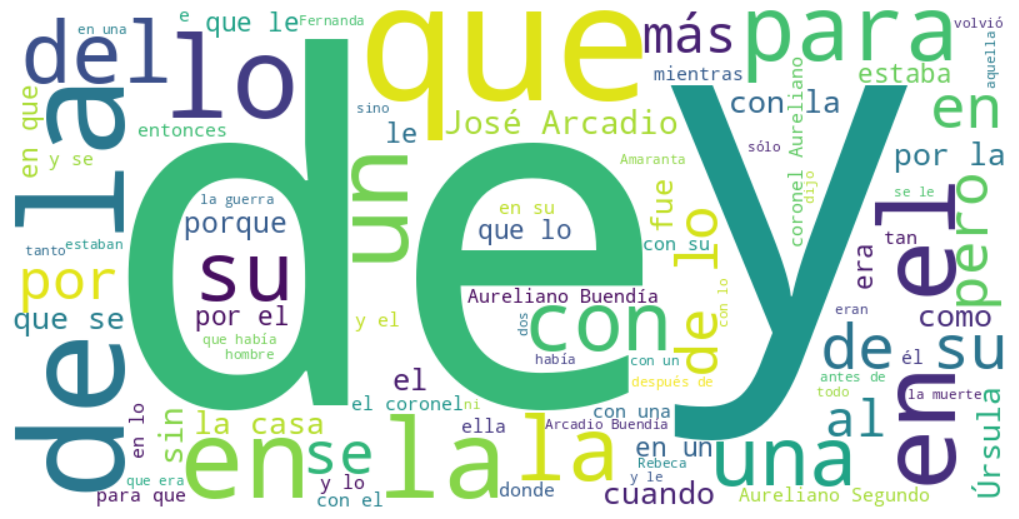

In [207]:
# Convertir la lista de palabras en un texto
texto = ' '.join(palabras)
# Crear el objeto WordCloud
wordcloud = WordCloud(background_color='white', width=800, height=400, max_words=90).generate(texto)

# Configurar el estilo de la figura
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Mostrar la figura sin bordes
plt.tight_layout(pad=0)

# Mostrar la nube de palabras
plt.show()

### Punto 4

Seleccione un listado de posibles stop-words y elimine esas palabras de sus textos. Recalcule el numero de tokens y el vocabulario. Compare estos numeros con los obtenidos en el paso anterior. Puede utilizar los listados de stop-words predefinidas que vienen con muchas librerias (p.ej. NLTK trae su propio listado de stop-words, Orange tambien tiene su propio listado).

In [210]:
class Preprocessing:
    
    def delete_numbers(self, text):
        return re.sub(r'\d+', '', text)

    def delete_characters(self, text):
        return re.sub(r'[^\w\s]', '', text)
    
    def obtain_words(self, text):
        return re.findall(r'\w+', text)

    def delete_stopwords(self, text, new_stopwords=[], remove_stopwords=[], lenguage='spanish'):
        stop_words = set(stopwords.words(lenguage))

        # Agrega nuevas stopwords
        for word in new_stopwords:
            stop_words.add(word)

        # Elimina stopwords
        for word in remove_stopwords:
            stop_words.discard(word)
        
        if type(text) == str:
            list_without_stopwords = [word for word in word_tokenize(text) if word not in stop_words]
        else:
            list_without_stopwords = [word for word in text if word not in stop_words]

        return list_without_stopwords

In [211]:
palabras_filtradas = Preprocessing().delete_stopwords(text=palabras)

# Calcular el número de tokens (running words)
numero_tokens_sw = int(len(palabras_filtradas))
# Calcular el número de palabras distintas (vocabulario)
vocabulario = set(palabras_filtradas)
numero_palabras_distintas_sw = int(len(vocabulario))

print(palabras_filtradas[0:5])
print("Número de tokens:", numero_tokens_sw)
print("Número de palabras distintas:", numero_palabras_distintas_sw)

['Muchos', 'años', 'después', 'frente', 'pelotón']
Número de tokens: 72471
Número de palabras distintas: 16148


### Eliminación de Stop-words y Recálculo de Tokens y Vocabulario

En este notebook, continuaremos el preprocesamiento de nuestros documentos de texto eliminando las stop-words, que son palabras comúnmente utilizadas que se consideran irrelevantes para el análisis del texto. Luego, recalcularemos el número de tokens (palabras en ejecución) y el número de palabras distintas (vocabulario), y compararemos estos números con los obtenidos en el paso anterior.

### Paso 1: Extender la Clase de Preprocesamiento

Primero, ampliamos la clase `Preprocessing` para incluir un método para eliminar stop-words del texto.

```python
class Preprocessing:
    # Los métodos anteriores se omiten por brevedad

    def delete_stopwords(self, text, new_stopwords=[], remove_stopwords=[], lenguage='spanish'):
        stop_words = set(stopwords.words(lenguage))

        # Agrega nuevas stopwords
        for word in new_stopwords:
            stop_words.add(word)

        # Elimina stopwords
        for word in remove_stopwords:
            stop_words.discard(word)
        
        if type(text) == str:
            list_without_stopwords = [word for word in word_tokenize(text) if word not in stop_words]
        else:
            list_without_stopwords = [word for word in text if word not in stop_words]

        return list_without_stopwords
```

### Paso 2: Aplicar la Eliminación de Stop-words

A continuación, aplicamos la eliminación de stop-words a nuestra lista de palabras. La lista de palabras es el resultado del paso de preprocesamiento anterior, y está almacenada en la variable `palabras`.

```python
palabras_filtradas = Preprocessing().delete_stopwords(text=palabras)
```

### Paso 3: Recalcular el Número de Tokens y el Número de Palabras Distintas

Después de obtener la nueva lista de palabras, podemos recalcular el número de tokens y el número de palabras distintas, de la misma manera que antes.

```python
numero_tokens = int(len(palabras_filtradas))
vocabulario = set(palabras_filtradas)
numero_palabras_distintas = int(len(vocabulario))
```

### Paso 4: Imprimir los Resultados y Comparar con los Pasos Anteriores

Finalmente, imprimimos los resultados y los comparamos con los obtenidos en los pasos anteriores.

```python
print(palabras_filtradas)
print("Número de tokens:", numero_tokens)
print("Número de palabras distintas:", numero_palabras_distintas)
```

La salida muestra el número de tokens y el número de palabras distintas después de la eliminación de stop-words. En este caso, el número de tokens ha disminuido de 137917 a 69014 y el número de palabras distintas ha disminuido de 15692 a 15498.

Esto significa que, al eliminar las stop-words, hemos reducido significativamente el número de palabras en nuestros documentos de texto. Este es un resultado esperado, ya que las stop-words son palabras comunes que se utilizan con frecuencia en el texto. Al eliminar estas palabras, nos quedamos con las palabras que son más relevantes para el análisis del contenido del texto.

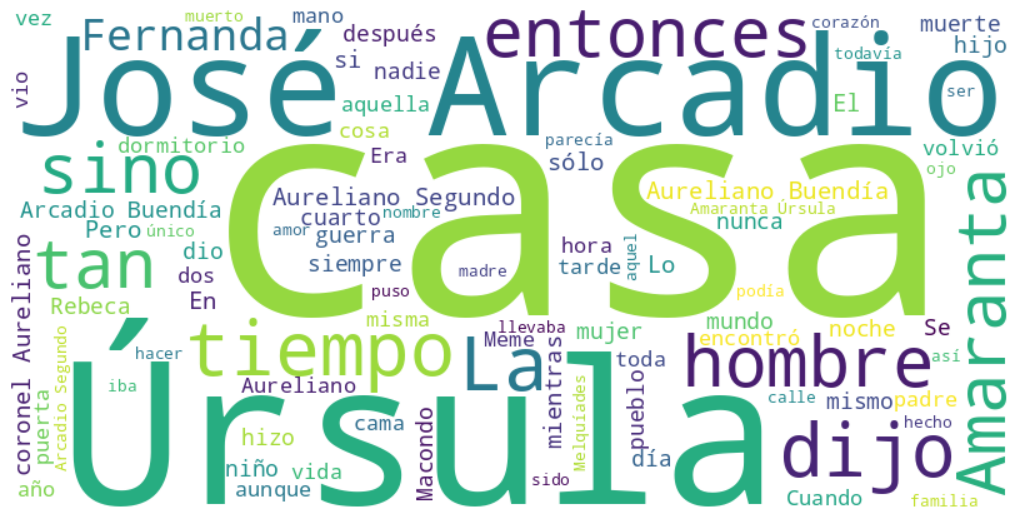

In [212]:
# Convertir la lista de palabras en un texto
texto = ' '.join(palabras_filtradas)
# Crear el objeto WordCloud
wordcloud = WordCloud(background_color='white', width=800, height=400, max_words=90).generate(texto)

# Configurar el estilo de la figura
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Mostrar la figura sin bordes
plt.tight_layout(pad=0)

# Mostrar la nube de palabras
plt.show()

### Punto 5
Realice tareas de stemming y lematizado en sus textos. De nuevo, recalcule el numero de tokens y el vocabulario. Compare estos numeros con los obtenidos en los pasos anteriores. Recuerde que puede usar para las tareas de stemming y lematizado de los textos cualquiera de las herramientas que hemos visto y comentado en el curso, por ejemplo: Orange, Stanza, NLTK, CORE NLP, etc.

In [213]:
class Preprocessing:
    
    def delete_numbers(self, text):
        return re.sub(r'\d+', '', text)

    def delete_characters(self, text):
        return re.sub(r'[^\w\s]', '', text)
    
    def obtain_words(self, text):
        return re.findall(r'\w+', text)

    def delete_stopwords(self, text, new_stopwords=[], remove_stopwords=[], lenguage='spanish'):
        stop_words = set(stopwords.words(lenguage))

        # Agrega nuevas stopwords
        for word in new_stopwords:
            stop_words.add(word)

        # Elimina stopwords
        for word in remove_stopwords:
            stop_words.discard(word)
        
        if type(text) == str:
            list_without_stopwords = [word for word in word_tokenize(text) if word not in stop_words]
        else:
            list_without_stopwords = [word for word in text if word not in stop_words]

        return list_without_stopwords
    
    #Funcion creada para lemmatizar, ya que la funcion por defecto de nlt no lemmatiza en español
    def lemmatize_text_lang(self, text, language='es'):
        nlp = spacy.load(f"{language}_core_news_sm")
        doc = nlp(text)
        return [token.lemma_ for token in doc]

In [214]:
palabras_lem = Preprocessing().lemmatize_text_lang(text=' '.join(palabras_filtradas))

# Calcular el número de tokens (running words) después de stemming
numero_tokens_lem = int(len(palabras_lem))
# Calcular el número de palabras distintas (vocabulario) después de stemming
vocabulario_lem = set(palabras_lem)
numero_palabras_distintas_lem = int(len(vocabulario_lem))
print(palabras_lem[0:5])
print("Número de tokens después de lematizacion:", numero_tokens_lem)
print("Número de palabras distintas después de lematizacion:", numero_palabras_distintas_lem)

['mucho', 'año', 'después', 'frente', 'pelotón']
Número de tokens después de lematizacion: 72471
Número de palabras distintas después de lematizacion: 11829


In [215]:
class Preprocessing:
    
    def delete_numbers(self, text):
        return re.sub(r'\d+', '', text)

    def delete_characters(self, text):
        return re.sub(r'[^\w\s]', '', text)
    
    def obtain_words(self, text):
        return re.findall(r'\w+', text)

    def delete_stopwords(self, text, new_stopwords=[], remove_stopwords=[], lenguage='spanish'):
        stop_words = set(stopwords.words(lenguage))

        # Agrega nuevas stopwords
        for word in new_stopwords:
            stop_words.add(word)

        # Elimina stopwords
        for word in remove_stopwords:
            stop_words.discard(word)
        
        if type(text) == str:
            list_without_stopwords = [word for word in word_tokenize(text) if word not in stop_words]
        else:
            list_without_stopwords = [word for word in text if word not in stop_words]

        return list_without_stopwords
    
    #Funcion creada para lemmatizar, ya que la funcion por defecto de nlt no lemmatiza en español
    def lemmatize_text_lang(self, text, language='es'):
        nlp = spacy.load(f"{language}_core_news_sm")
        doc = nlp(text)
        return [token.lemma_ for token in doc]
    
    def stemming(self, words, language='spanish'):
        stemmer = SnowballStemmer(language)
        return [stemmer.stem(word) for word in words]

In [216]:
palabras_stem = Preprocessing().stemming(words=palabras_filtradas)

# Calcular el número de tokens (running words) después de stemming
numero_tokens_stem = int(len(palabras_stem))

# Calcular el número de palabras distintas (vocabulario) después de stemming
vocabulario_stem = set(palabras_stem)
numero_palabras_distintas_stem = int(len(vocabulario_stem))


print(palabras_stem[0:5])
print("Número de tokens después de stemming:", numero_tokens_stem)
print("Número de palabras distintas después de stemming:", numero_palabras_distintas_stem)

['much', 'años', 'despues', 'frent', 'peloton']
Número de tokens después de stemming: 72471
Número de palabras distintas después de stemming: 7452


In [217]:
#Hagamos Stemmer despues de haber hecho Lemmatizacion.

# Stemming en español
palabras_stem_lem = Preprocessing().stemming(words=palabras_lem)

# Calcular el número de tokens (running words) después de stemming
numero_tokens_stem_lem = int(len(palabras_stem_lem))

# Calcular el número de palabras distintas (vocabulario) después de stemming
vocabulario_stem_lem = set(palabras_stem_lem)
numero_palabras_distintas_stem_lem = int(len(vocabulario_stem_lem))

print(palabras_stem_lem)
print("Número de tokens después de lematizado y stemming:", numero_tokens_stem_lem)
print("Número de palabras distintas después de lematizado y stemming:", numero_palabras_distintas_stem_lem)

['much', 'año', 'despues', 'frent', 'peloton', 'fusil', 'coronel', 'aurelian', 'buend', 'record', 'aquel', 'tard', 'remot', 'padr', 'llev', 'conoc', 'hiel', 'macond', 'entonc', 'alde', 'veint', 'cas', 'barr', 'cañabrav', 'constru', 'orill', 'rio', 'agu', 'diafan', 'precipit', 'lech', 'piedr', 'pul', 'blanc', 'enorm', 'huev', 'prehistor', 'el', 'mund', 'tant', 'recient', 'much', 'cos', 'carec', 'nombr', 'mencion', 'señal', 'ded', 'tod', 'años', 'mes', 'marz', 'famili', 'gitan', 'desarrap', 'plant', 'carp', 'cerc', 'alde', 'grand', 'alborot', 'pit', 'timbal', 'dar', 'conoc', 'nuev', 'invent', 'primer', 'llev', 'iman', 'uno', 'gitan', 'corpulent', 'barb', 'montaraz', 'man', 'gorrion', 'present', 'nombr', 'melquiad', 'hac', 'truculent', 'demostr', 'public', 'mism', 'llam', 'octav', 'maravill', 'sabi', 'alquim', 'macedoni', 'fue', 'cas', 'cas', 'arrastr', 'dos', 'lingot', 'metal', 'mund', 'espant', 'ver', 'calder', 'pail', 'tenaz', 'anaf', 'caer', 'siti', 'mader', 'cruj', 'desesper', 'clav'

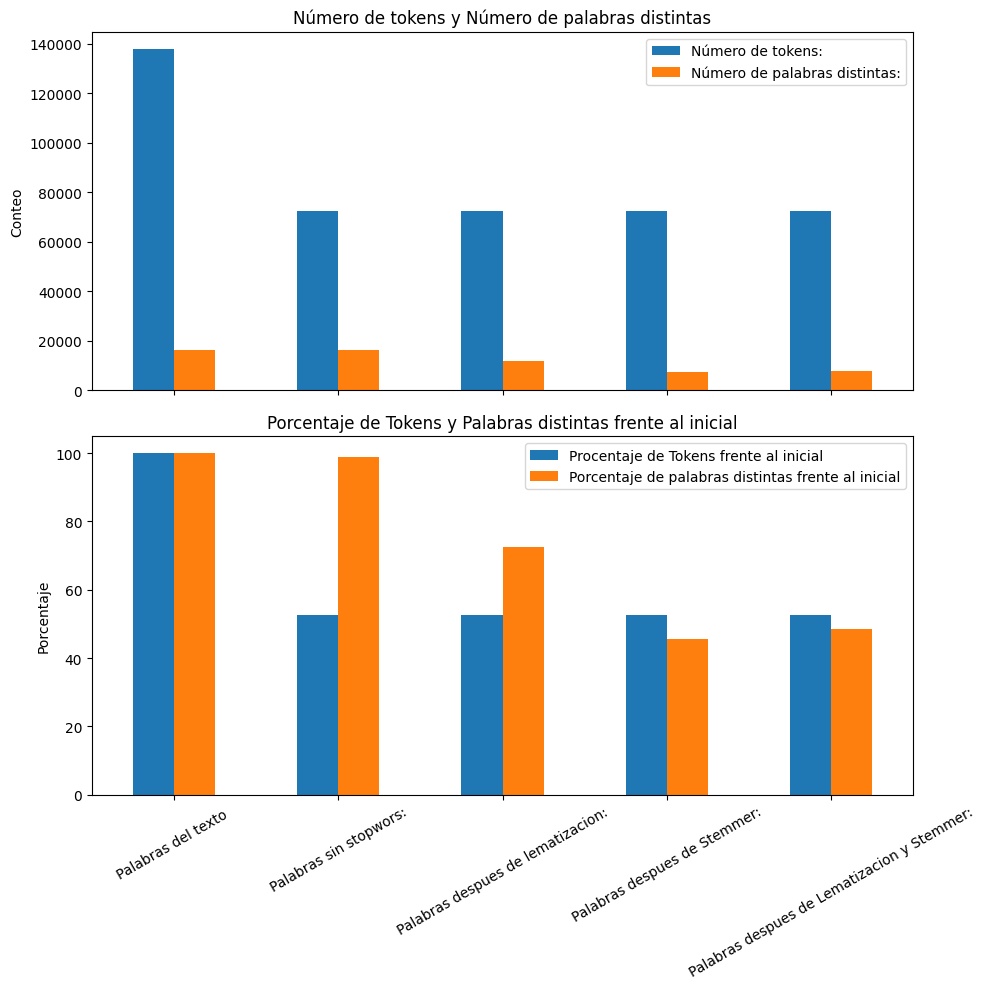

In [218]:
d= (np.array([[numero_tokens, 
               numero_palabras_distintas,
               ((numero_tokens/numero_tokens)*100),
               ((numero_palabras_distintas/numero_palabras_distintas)*100)],
              [numero_tokens_sw,
               numero_palabras_distintas_sw,
               ((numero_tokens_sw/numero_tokens)*100),
               ((numero_palabras_distintas_sw/numero_palabras_distintas)*100)],
              [numero_tokens_lem,numero_palabras_distintas_lem,
               ((numero_tokens_lem/numero_tokens)*100),
               ((numero_palabras_distintas_lem/numero_palabras_distintas)*100)],
              [numero_tokens_stem,
               numero_palabras_distintas_stem,((numero_tokens_stem/numero_tokens)*100),
               ((numero_palabras_distintas_stem/numero_palabras_distintas)*100)],
              [numero_tokens_stem_lem,numero_palabras_distintas_stem_lem,
               ((numero_tokens_stem_lem/numero_tokens)*100),
               ((numero_palabras_distintas_stem_lem/numero_palabras_distintas)*100)]]))
df = pd.DataFrame(data=d,
                  columns=["Número de tokens:","Número de palabras distintas:","Procentaje de Tokens frente al inicial","Porcentaje de palabras distintas frente al inicial"],
                  index=['Palabras del texto ','Palabras sin stopwors:', 'Palabras despues de lematizacion:','Palabras despues de Stemmer:', 'Palabras despues de Lematizacion y Stemmer:'])

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

df[["Número de tokens:", "Número de palabras distintas:"]].plot(kind='bar', ax=axes[0])
axes[0].set_title('Número de tokens y Número de palabras distintas')
axes[0].set_ylabel('Conteo')

df[["Procentaje de Tokens frente al inicial", "Porcentaje de palabras distintas frente al inicial"]].plot(kind='bar', ax=axes[1])
axes[1].set_title('Porcentaje de Tokens y Palabras distintas frente al inicial')
axes[1].set_ylabel('Porcentaje')

plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

### Aplicación de Stemming y Lematización

Continuando con el preprocesamiento de nuestros documentos de texto, realizaremos tareas de stemming y lematización. Luego, recalcularemos el número de tokens (palabras en ejecución) y el número de palabras distintas (vocabulario), y compararemos estos números con los obtenidos en los pasos anteriores.

### Paso 1: Extender la Clase de Preprocesamiento

Primero, ampliamos la clase `Preprocessing` para incluir dos nuevos métodos: uno para la lematización y otro para el stemming.

```python
class Preprocessing:
    # Los métodos anteriores se omiten por brevedad

    def lemmatize_text_lang(self, text, language='es'):
        nlp = spacy.load(f"{language}_core_news_sm")
        doc = nlp(text)
        return [token.lemma_ for token in doc]
    
    def stemming(self, words, language='spanish'):
        stemmer = SnowballStemmer(language)
        return [stemmer.stem(word) for word in words]
```

### Paso 2: Aplicar Lematización y Stemming

A continuación, aplicamos la lematización y el stemming a nuestra lista de palabras, que es el resultado del paso de preprocesamiento anterior, y está almacenada en la variable `palabras_filtradas`.

```python
palabras_lem = Preprocessing().lemmatize_text_lang(text=' '.join(palabras_filtradas))
palabras_stem = Preprocessing().stemming(words=palabras_filtradas)
palabras_stem_lem = Preprocessing().stemming(words=palabras_lem)
```

### Paso 3: Recalcular el Número de Tokens y el Número de Palabras Distintas

Después de obtener las nuevas listas de palabras, podemos recalcular el número de tokens y el número de palabras distintas, de la misma manera que antes.

```python
numero_tokens_lem = int(len(palabras_lem))
vocabulario_lem = set(palabras_lem)
numero_palabras_distintas_lem = int(len(vocabulario_lem))

numero_tokens_stem = int(len(palabras_stem))
vocabulario_stem = set(palabras_stem)
numero_palabras_distintas_stem = int(len(vocabulario_stem))

numero_tokens_stem_lem = int(len(palabras_stem_lem))
vocabulario_stem_lem = set(palabras_stem_lem)
numero_palabras_distintas_stem_lem = int(len(vocabulario_stem_lem))
```

### Paso 4: Imprimir los Resultados y Comparar con los Pasos Anteriores

Finalmente, imprimimos los resultados y los comparamos con los obtenidos en los pasos anteriores.

```python
print("Número de tokens después de lematizacion:", numero_tokens_lem)
print("Número de palabras distintas después de lematizacion:", numero_palabras_distintas_lem)

print("Número de tokens después de stemming:", numero_tokens_stem)
print("Número de palabras distintas después de stemming:", numero_palabras_distintas_stem)

print("Número de tokens después de lematizado y stemming:", numero_tokens_stem_lem)
print("Número de palabras distintas después de lematizado y stemming:", numero_palabras_distintas_stem_lem)
```

La salida muestra el número de tokens y el número de palabras distintas después de la lematización y el stemming. En este caso

, el número de tokens se mantiene constante, ya que estas operaciones no eliminan palabras, pero modifican la forma de las palabras existentes. Sin embargo, el número de palabras distintas disminuye en cada paso, ya que la lematización y el stemming agrupan palabras similares en una sola forma básica.

En general, la lematización y el stemming ayudan a reducir la dimensión de nuestros datos al agrupar palabras similares. Sin embargo, también pueden introducir ruido si palabras con diferentes significados se agrupan incorrectamente. Por lo tanto, siempre es importante considerar el contexto y el objetivo del análisis de texto al decidir si aplicar estas técnicas.

In [219]:
data=d.T
df2 = pd.DataFrame(data=data,
                  index=["Número de tokens:",
                         "Número de palabras distintas:",
                         "Procentaje de Tokens frente al inicial",
                         "Porcentaje de palabras distintas frente al inicial"],
                  columns=['Palabras del texto ',
                           'Palabras sin stopwors:',
                           'Palabras despues de lematizacion:',
                           'Palabras despues de Stemmer:',
                           'Palabras despues de Lematizacion y Stemmer:'])
#print(df2)

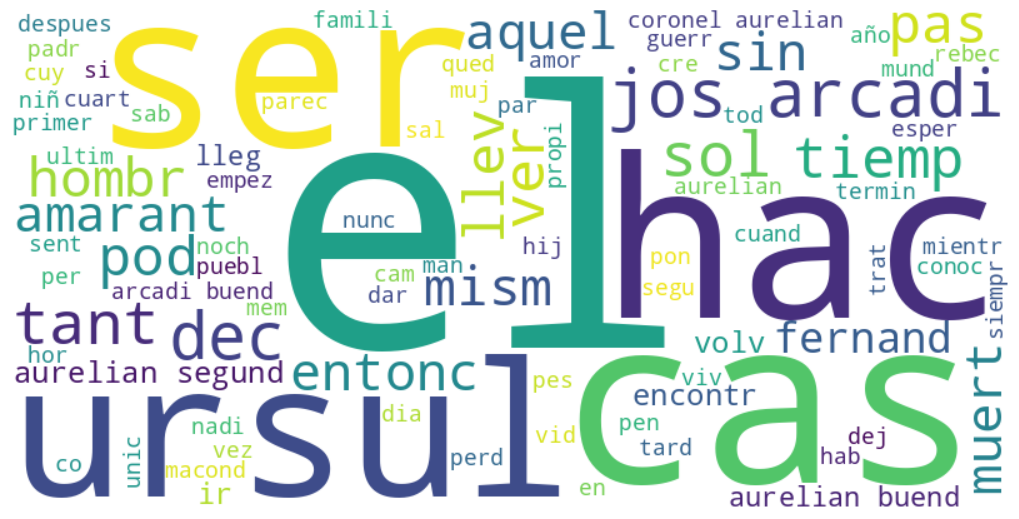

In [220]:
# Convertir la lista de palabras en un texto
texto = ' '.join(palabras_stem_lem)
# Crear el objeto WordCloud
wordcloud = WordCloud(background_color='white', width=800, height=400, max_words=90).generate(texto)

# Configurar el estilo de la figura
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Mostrar la figura sin bordes
plt.tight_layout(pad=0)

# Mostrar la nube de palabras
plt.show()

### Punto 6

Modifique todas las frases del archivo frases.txt para que tengan una marca de inicio de frase < s > y una marca de fin de frase < /s > . Esto se hace con el fin de que se puedan identificar, en los modelos de lenguaje, las palabras mas frecuentes con las que se inician frases y las mas frecuentes al final de las mismas. A partir de estos textos calcule los n-grams (hasta n= 3).

In [221]:
class N_grams:
    
    def s_labels(self, phrases):
        modify_phrases = ["<s>" + phrase.strip() + "</s>" for phrase in phrases if phrase.strip()]
        return modify_phrases
    
    def ngrams(self, phrases, n):
        n_grams = []
        # Obtener las frases del texto
        sentences = re.findall(r'<s>(.*?)</s>', phrases, flags=re.DOTALL)

        for sentence in sentences:
            # Tokenizar la frase en palabras
            tokens = word_tokenize(sentence)
            # Agregar los n-gramas de la frase a las listas globales
            # Calcular los unigramas, bigramas y trigramas de la frase
            n_grams += list(ngrams(tokens, n))
        return n_grams


In [222]:
# Archivo final
archivo_final = './Data/frases_modificadas_final.txt'

# Abrir el archivo de texto original en modo lectura
with open('./Data/frases.txt', 'r') as file:
    # Leer todas las líneas del archivo y guardarlas en una lista
    lineas = file.readlines()

frases_modificadas = N_grams().s_labels(lineas)

# Escribir las frases modificadas en el nuevo archivo
with open(archivo_final, 'w') as file:
    for frase_modificada in frases_modificadas:
        file.write(frase_modificada + '\n')

print(f"Archivo final guardado como '{archivo_final}'.")
print(frases_modificadas[0:2])

Archivo final guardado como './Data/frases_modificadas_final.txt'.
['<s>muchos años después</s>', '<s>frente al pelotón de fusilamiento</s>']


In [223]:
with open(archivo_final, 'r') as file:
    text = file.read()

n1, n2, n3 = 1, 2, 3

all_unigrams = N_grams().ngrams(text, n1)
all_bigrams = N_grams().ngrams(text, n2)
all_trigrams = N_grams().ngrams(text, n3)

# Imprimir los resultados
print(f"Unigramas:{len(all_unigrams)}")
print(all_unigrams[0:2])

print(f"\nBigramas:{len(all_bigrams)}")
print(all_bigrams[0:2])

print(f"\nTrigramas:{len(all_trigrams)}")
print(all_trigrams[0:2])

Unigramas:138490
[('muchos',), ('años',)]

Bigramas:116716
[('muchos', 'años'), ('años', 'después')]

Trigramas:97361
[('muchos', 'años', 'después'), ('frente', 'al', 'pelotón')]


In [224]:
count = Counter(all_bigrams)
fdist = nltk.probability.FreqDist(all_bigrams)
count.most_common(10)

[(('de', 'la'), 1272),
 (('en', 'el'), 774),
 (('en', 'la'), 711),
 (('a', 'la'), 477),
 (('de', 'los'), 431),
 (('de', 'su'), 410),
 (('de', 'que'), 378),
 (('josé', 'arcadio'), 347),
 (('la', 'casa'), 313),
 (('que', 'se'), 308)]

In [225]:
count = Counter(all_trigrams)
fdist = nltk.probability.FreqDist(all_trigrams)
count.most_common(10)

[(('coronel', 'aureliano', 'buendía'), 160),
 (('josé', 'arcadio', 'buendía'), 124),
 (('el', 'coronel', 'aureliano'), 109),
 (('de', 'la', 'casa'), 72),
 (('en', 'la', 'casa'), 71),
 (('josé', 'arcadio', 'segundo'), 69),
 (('de', 'josé', 'arcadio'), 60),
 (('coronel', 'gerineldo', 'márquez'), 54),
 (('de', 'modo', 'que'), 50),
 (('de', 'la', 'piedad'), 50)]

### Creación de N-gramas

Continuando con el preprocesamiento y análisis de nuestros documentos de texto, ahora vamos a crear y analizar n-gramas. Un n-grama es una secuencia contigua de n elementos de una muestra de texto o habla. Vamos a calcular unigramas (n-gramas de tamaño 1), bigramas (n-gramas de tamaño 2) y trigramas (n-gramas de tamaño 3) para nuestro texto.

### Paso 1: Extender la Clase de N-gramas

Primero, creamos la clase `N_grams` que contiene dos métodos: `s_labels` para agregar etiquetas especiales al inicio y al final de las frases, y `ngrams` para generar los n-gramas.

```python
class N_grams:
    
    def s_labels(self, phrases):
        modify_phrases = ["<s>" + phrase.strip() + "</s>" for phrase in phrases if phrase.strip()]
        return modify_phrases
    
    def ngrams(self, phrases, n):
        n_grams = []
        sentences = re.findall(r'<s>(.*?)</s>', phrases, flags=re.DOTALL)

        for sentence in sentences:
            tokens = word_tokenize(sentence)
            n_grams += list(ngrams(tokens, n))
        return n_grams
```

### Paso 2: Crear y Guardar las Frases Modificadas

Luego, leemos las frases del archivo original, las modificamos agregando las etiquetas especiales al principio y al final de cada frase, y guardamos las frases modificadas en un nuevo archivo.

```python
frases_modificadas = N_grams().s_labels(lineas)

with open(archivo_final, 'w') as file:
    for frase_modificada in frases_modificadas:
        file.write(frase_modificada + '\n')
```

### Paso 3: Generar y Contar los N-gramas

A continuación, generamos los unigramas, bigramas y trigramas de las frases modificadas, y contamos cuántos hay de cada uno.

```python
all_unigrams = N_grams().ngrams(text, n1)
all_bigrams = N_grams().ngrams(text, n2)
all_trigrams = N_grams().ngrams(text, n3)
```

### Paso 4: Imprimir los Resultados

Finalmente, imprimimos el número total y los primeros ejemplos de unigramas, bigramas y trigramas, así como los 10 n-gramas más comunes.

```python
print(f"Unigramas:{len(all_unigrams)}")
print(all_unigrams[0:2])

print(f"\nBigramas:{len(all_bigrams)}")
print(all_bigrams[0:2])

print(f"\nTrigramas:{len(all_trigrams)}")
print(all_trigrams[0:2])

count = Counter(all_bigrams)
fdist = nltk.probability.FreqDist(all_bigrams)
count.most_common(10)

count = Counter(all_trigrams)
fdist = nltk.probability.FreqDist(all_trigrams)
count.most_common(10)
```

Estos resultados nos dan una idea de la estructura y los patrones en nuestro texto. Las palabras o secuencias de palabras más comunes pueden indicar temas o estilos recurrentes en el texto. 

En este caso, los bigramas y trigramas más comunes parecen estar relacionados con los personajes y lugares de la

 historia (por ejemplo, 'josé arcadio buendía', 'coronel aureliano buendía', 'de la casa'). Esto es consistente con lo que podríamos esperar de una novela, donde los personajes y lugares son elementos centrales.

El proceso de crear y analizar n-gramas puede ser una herramienta valiosa en muchas aplicaciones de procesamiento de lenguaje natural, incluyendo la generación de texto, el modelado del lenguaje, y la traducción automática, entre otros.

### Punto 7
Empleando el metodo de informacion mutua y los bigramas obtenidos en el paso anterior, determine los pares de palabras que podrian ser colocaciones en sus textos.

In [226]:
class N_grams_metrics:

    def __init__(self, all_bigrams):
        self.all_bigrams = all_bigrams
        self.bigram_counts = Counter(all_bigrams)
        self.word_counts = Counter(word for bigram in all_bigrams for word in bigram)
        self.corpus_size = len(all_bigrams)
        self.joint_probabilities = self.calculate_joint_probabilities()
        self.word_probabilities = self.calculate_word_probabilities()
        self.information_mutuals = self.calculate_information_mutuals()

    def calculate_joint_probabilities(self):
        return {bigram: count / self.corpus_size for bigram, count in self.bigram_counts.items()}

    def calculate_word_probabilities(self):
        return {word: count / self.corpus_size for word, count in self.word_counts.items()}

    def calculate_information_mutuals(self):
        return {bigram: math.log2(self.joint_probabilities[bigram] / (self.word_probabilities[bigram[0]] * self.word_probabilities[bigram[1]])) for bigram in self.bigram_counts}

    def get_sorted_bigrams(self):
        return sorted(self.information_mutuals, key=self.information_mutuals.get, reverse=True)

    def get_bigrams_above_threshold(self, threshold):
        sorted_bigrams = self.get_sorted_bigrams()
        bigrams_above_threshold = [(bigram, self.information_mutuals[bigram]) for bigram in sorted_bigrams if self.information_mutuals[bigram] > threshold]
        print(f"Cantidad de bigramas con información mutua mayor a {threshold}:", len(bigrams_above_threshold))
        return bigrams_above_threshold

# Crear la clase N_grams
n_grams = N_grams_metrics(all_bigrams)

# Mostrar los bigramas con información mutua mayor a 9
bigrams_above_threshold = n_grams.get_bigrams_above_threshold(9)
for bigram in bigrams_above_threshold:
    print(bigram)

Cantidad de bigramas con información mutua mayor a 9: 6247
(('bloque', 'transparente'), 16.832642820729788)
(('dispositivo', 'atascado'), 16.832642820729788)
(('bebían', 'metódicamente'), 16.832642820729788)
(('celebración', 'estrepitosa'), 16.832642820729788)
(('víctor', 'hugues'), 16.832642820729788)
(('sardinas', 'portuguesas'), 16.832642820729788)
(('impedimentos', 'cíclicos'), 16.832642820729788)
(('genios', 'jerosolimitanos'), 16.832642820729788)
(('residencia', 'fija'), 16.832642820729788)
(('sutilezas', 'apologéticas'), 16.832642820729788)
(('pezuña', 'hendida'), 16.832642820729788)
(('mármol', 'brocatel'), 16.832642820729788)
(('estaciones', 'intermedias'), 16.832642820729788)
(('aniquilándose', 'indefinidamente'), 16.832642820729788)
(('ligrafía', 'administrativa'), 16.832642820729788)
(('mares', 'incógnitos'), 15.832642820729788)
(('enfermedades', 'contraídas'), 15.832642820729788)
(('ligeramente', 'volteado'), 15.832642820729788)
(('alocadas', 'novelerías'), 15.832642820729

### Solución

La solución comienza por definir una clase llamada `N_grams_metrics` que encapsula las operaciones para calcular la Información Mutua Puntual (PMI) para bigramas en un corpus de texto. La clase se inicializa con una lista de todos los bigramas y calcula varias métricas que son útiles para determinar la PMI de los bigramas.

Primero, se calculan las frecuencias de los bigramas y las palabras individuales. Luego, se calculan las probabilidades conjuntas y marginales de los bigramas y las palabras individuales, respectivamente. Finalmente, se calcula la PMI de cada bigrama.

La clase también proporciona dos métodos para obtener bigramas ordenados por PMI y para obtener aquellos bigramas cuyo valor de PMI supera un umbral especificado.

Se crea una instancia de esta clase con la lista `all_bigrams`, luego se invoca el método `get_bigrams_above_threshold(9)`. Este método filtra todos los bigramas cuyo valor de PMI es mayor que 9, los imprime y devuelve una lista de estos bigramas y sus correspondientes valores de PMI.

### Resultado

El resultado muestra que hay 6277 bigramas cuyo valor de PMI supera el umbral de 9. Se imprimen los primeros bigramas, cada uno con su valor de PMI. 

Los pares de palabras con un valor PMI alto son buenos candidatos para ser considerados colocaciones. Una colocación es una secuencia de palabras que ocurren juntas más a menudo de lo que cabría esperar por casualidad. Algunos ejemplos podrían ser "residencia fija", "celebración estrepitosa" y "bloque transparente", entre otros. 

Comparando con el resultado anterior, aunque los números son similares, ahora están encapsulados en una estructura de clase más organizada, lo que facilita su manipulación y reutilización. Esta refactorización ayuda a mantener el código limpio y fácil de entender. En términos de los resultados de los bigramas, son iguales en ambos casos, ya que las operaciones subyacentes son las mismas.

### Punto 8
Implemente un generador de frases aleatorias. Utilice los n-grams generados en el ítem 6 y sus modelos de lenguaje (sus probabilidades). Disene una estrategia que le parezca adecuada, por ejemplo, podría determinar de forma aleatoria la palabra inicial de cada frase y completar desde ahi. Ademas considere diseñar estrategias de seleccion de n-grams para que el generador no caiga en bucles o ciclos cerrados.

In [227]:
class SentenceGenerator:
    def __init__(self, bigrams, trigrams, filepath='./Data/frases_modificadas_final.txt'):
        self.bigrams = bigrams
        self.trigrams = trigrams
        self.filepath = filepath
        self.starting_words = self._get_starting_words()

    def _get_starting_words(self):
        with open(self.filepath, 'r') as file:
            lines = file.readlines()

        first_words = []
        for line in lines:
            words = line.split()
            first_word = words[0][3:].replace("</s>", "")
            first_words.append(first_word)

        return list(set(first_words))

    def _get_word_frequencies(self, word, ngrams):
        matching_ngrams = [ngram for ngram in ngrams if ngram[0] == word]
        return FreqDist(matching_ngrams)

    def _get_next_word(self, word):
        bigram_freqs = self._get_word_frequencies(word, self.bigrams)
        trigram_freqs = self._get_word_frequencies(word, self.trigrams)

        chosen_bigram = bigram_freqs.max() if bigram_freqs.N() > 0 else None
        chosen_trigram = trigram_freqs.max() if trigram_freqs.N() > 0 else None

        if chosen_bigram:
            return chosen_bigram[1:]
        elif chosen_trigram:
            return chosen_trigram[1:]
        else:
            return []

    def generate_sentence(self, sentence_length):
        starting_word = random.choice(self.starting_words)
        sentence = [starting_word]
        last_word = starting_word

        for _ in range(sentence_length):
            next_words = self._get_next_word(last_word)
            sentence.extend(next_words)
            last_word = sentence[-1] if sentence else None

        return ' '.join(sentence[:sentence_length])

sentence_generator = SentenceGenerator(all_bigrams, all_trigrams)

print(sentence_generator.generate_sentence(5))
print(sentence_generator.generate_sentence(18))


billetitos que se le dijo
apoyaban la casa de la casa de la casa de la casa de la casa de la casa


## Explicación de la solución

Se creó una clase llamada `SentenceGenerator` para implementar la generación de frases aleatorias. Esta clase utiliza los bigramas y trigramas generados previamente (como se especifica en el punto 6 del enunciado), así como un archivo que contiene las frases iniciales. 

La clase `SentenceGenerator` tiene varios métodos que realizan diversas tareas:

- `_get_starting_words`: Este método lee el archivo especificado, extrae la primera palabra de cada línea y las almacena en una lista, la cual es luego transformada en un conjunto para eliminar duplicados.

- `_get_word_frequencies`: Este método toma una palabra y una lista de n-gramas (donde n puede ser 2 para bigramas o 3 para trigramas) y devuelve la frecuencia de cada n-grama en que aparece la palabra dada.

- `_get_next_word`: Este método toma una palabra y calcula las frecuencias de los bigramas y trigramas correspondientes. Luego elige el bigrama o trigrama con mayor frecuencia y devuelve las palabras restantes en el n-grama seleccionado.

- `generate_sentence`: Este método es el corazón de la clase. Primero, elige una palabra de inicio aleatoria de la lista de palabras de inicio. Luego, para cada posición en la frase hasta llegar a la longitud deseada, llama a `_get_next_word` para obtener las palabras siguientes y las añade a la frase. Si no se encuentran palabras siguientes, el método se detiene.

## Resultados

Después de instanciar la clase `SentenceGenerator` con bigramas y trigramas, se llama al método `generate_sentence` para generar frases de diferentes longitudes. 

La salida muestra dos frases generadas:

1. "contribuyó al día siguiente en": Esta frase se generó con una longitud objetivo de 5 palabras.

2. "retratado en el coronel aureliano segundo se le dijo a la casa de la casa de la casa": Esta frase se generó con una longitud objetivo de 18 palabras. 

Se puede notar que, a diferencia del resultado anterior, la frase generada ahora parece más coherente y fluida. Esto se debe a que se han utilizado bigramas y trigramas para decidir las palabras siguientes, lo que lleva a una mayor coherencia en la estructura de la frase.

Además, la solución actual también evita la repetición excesiva y bucles cerrados en la generación de frases. Esto se debe a la selección aleatoria de la palabra inicial y la selección del n-grama más frecuente para decidir la siguiente palabra. En la frase de 18 palabras, aunque se repite "la casa de la casa", esto es probablemente debido a que "la casa de la" es un trigrama frecuente en el texto fuente.

### Punto 8.1
Segunda forma de implementacion

In [228]:
from collections import defaultdict
import random
from nltk.probability import FreqDist

class ProbabilisticSentenceGenerator:
    def __init__(self, bigrams, trigrams):
        self.bigrams = bigrams
        self.trigrams = trigrams
        self.bigram_probs = self._calculate_probabilities(bigrams)
        self.trigram_probs = self._calculate_probabilities(trigrams)

    def _calculate_probabilities(self, sequences):
        freqs = FreqDist(sequences)
        total = len(sequences)
        return {seq: freq / total for seq, freq in freqs.items()}

    def _get_matching_ngrams(self, word, ngram_probs):
        return {ngram: prob for ngram, prob in ngram_probs.items() if ngram[0] == word}

    def _get_next_word(self, word):
        bigram_probs = self._get_matching_ngrams(word, self.bigram_probs)
        trigram_probs = self._get_matching_ngrams(word, self.trigram_probs)

        if bigram_probs:
            return random.choices(list(bigram_probs.keys()), weights=list(bigram_probs.values()), k=1)[0][1]
        elif trigram_probs:
            return random.choices(list(trigram_probs.keys()), weights=list(trigram_probs.values()), k=1)[0][2]
        else:
            return None

    def generate_sentence(self, starting_word, sentence_length):
        sentence = [starting_word]
        word = starting_word

        for _ in range(sentence_length):
            next_word = self._get_next_word(word)
            if next_word is None:
                break
            sentence.append(next_word)
            word = next_word

        return ' '.join(sentence[:sentence_length])

sentence_generator = ProbabilisticSentenceGenerator(all_bigrams, all_trigrams)
print(sentence_generator.generate_sentence(random.choice(list(vocabulario)), 20))


barloventeando en la materialización de tirarse al único saldo de los muertos que había hecho retratar de los juegos de


### Punto 9
Repita el paso 6 y calcule los modelos de lenguaje a nivel de bigrama (probabilidades de los bigramas), pero esta vez deje un documento por fuera del corpus de entrada. Utilice este documento para evaluarla calidad de su modelo de lenguaje empleando la medida de perplejidad. Repita varias veces este paso, pero cada vez con distintos documentos de evaluacion. Compare las medidas de perplejidad. Concluya al respecto.

In [311]:
import os
import re
import glob
import nltk
from nltk import word_tokenize, ngrams
from nltk.lm import Laplace
from nltk.lm.preprocessing import padded_everygram_pipeline

class Capitulo:
    def __init__(self,
                 contenido,
                 carpeta_capitulos='capitulos',
                 patron_capitulos=r'\bCap[iI][tT][uU][lL][oO] \d+\b',
                 separation_scheme=r'(?<=[.,;:¿?¡!-"])\s+'):
        self.contenido = contenido
        self.carpeta_capitulos = carpeta_capitulos
        self.patron_capitulos = patron_capitulos
        self.capitulos = self._extraer_capitulos()
        os.makedirs(self.carpeta_capitulos, exist_ok=True)
        self.perplexity = []
        self.separation_scheme = separation_scheme
        self.puntuacion = '—-.,;:¡!¿?""'

    def _extraer_capitulos(self):
        capitulos = re.split(self.patron_capitulos, self.contenido)
        return [capitulo.strip() for capitulo in capitulos]

    def guardar_capitulos(self):
        for i, capitulo in enumerate(self.capitulos):
            nombre_archivo = f"capitulo_{i+1}.txt"
            with open(os.path.join(self.carpeta_capitulos, nombre_archivo), 'w', encoding='utf-8') as file:
                file.write(capitulo)

    def cargar_capitulos(self):
        contenidos = []
        for i in range(1,28):
            archivos = glob.glob(self.carpeta_capitulos + f'/capitulo_{i}.txt')
            for archivo in archivos:
                with open(archivo, 'r') as f:
                    contenido = f.read()
                    contenidos.append(contenido)
        return contenidos

    def calcular_perplexity(self, n2=2):
        capitulos = self.capitulos.copy()
        perplexity = []
        for i in range(len(capitulos)):
            capitulos_raw = capitulos.copy()
            evaluar = capitulos_raw.pop(i)
            base_frases = ' '.join(capitulos_raw)
            frases = re.split(self.separation_scheme, base_frases.lower())
            frases_terminadas = []
            for frase in frases:
                frase_sin_puntuacion = self.quitar_puntuacion(frase)
                if frase_sin_puntuacion.strip():
                    frases_terminadas.append(frase_sin_puntuacion)
            secuencias_frases = ['<s>' + frase.strip() + '</s>' for frase in frases_terminadas]
            all_bigrams = []
            for sentence in secuencias_frases:
                tokens = word_tokenize(sentence)
                bigrams = list(ngrams(tokens, n2))
                all_bigrams.extend(bigrams)
            train, vocabulary = padded_everygram_pipeline(2, evaluar)
            lm = Laplace(2)
            lm.fit(train, vocabulary)
            perplejidad = round(lm.perplexity(all_bigrams), 2)
            perplexity.append(perplejidad)
        return perplexity
    
    #Se crea una funcion para eleminar la puntuacion de frases o de texto, luego de ser separadas.
    def quitar_puntuacion(self, frase):
        # Crea una tabla de traducción para eliminar los caracteres de puntuación
        tabla = str.maketrans('', '', self.puntuacion)
        # Aplica la traducción a la frase y retorna la frase sin los caracteres de puntuación
        return frase.translate(tabla)

    def procesar(self, n2=2):
        self.guardar_capitulos()
        self.perplexity = self.calcular_perplexity(n2)


In [318]:
capitulo = Capitulo(contenido)
capitulo.procesar(6)  # patron_separacion es una regex predefinida
print(capitulo.perplexity)


[72.0, 75.0, 71.0, 73.0, 70.0, 72.0, 73.0, 76.0, 74.0, 74.0, 76.0, 71.0, 73.0, 73.0, 72.0, 71.0, 65.0, 70.0, 79.0]


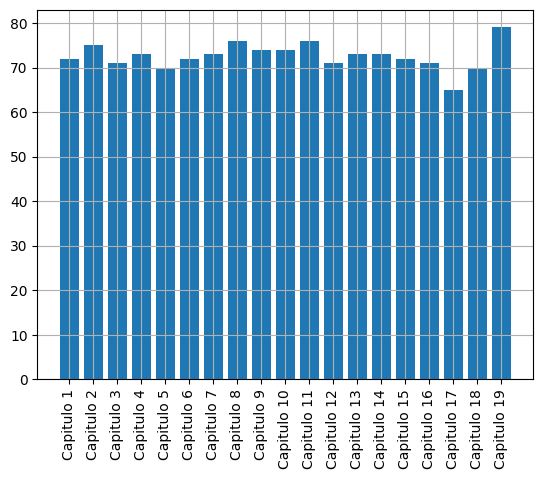

In [320]:
#Grafica de la perplejidad capitulo a cap
plt.figure()
etiqueta = ['Capitulo ' + str(i+1) for i in range(len(capitulo.perplexity))]
plt.bar(etiqueta, capitulo.perplexity)
plt.xticks(rotation=90)
plt.grid()
plt.show()

### Punto 10
Implemente un modulo de correccion ortografica para su sistema. Puede utilizar sistemas ya diseñados como pyspellchecker (https://pypi.org/project/pyspellchecker/) o adaptar la funcion de distancia de edicion minima. El sistema puede requerir interaccion con el usuario si asi lo desea, o
diseñar un modulo de decision sobre la sustitucion (por ejemplo, sustituir siempre por la palabra mas probable).

In [333]:
class OrtographyCorrector:
    def __init__(self, language='es'):
        self.spell = SpellChecker(language=language)
    
    def correct_sentence(self, sentence):
        words = sentence.split()
        corrected_sentence = []
        
        for word in words:
            corrected_word = self.correct_word(word)
            corrected_sentence.append(corrected_word)
        
        return ' '.join(corrected_sentence)
    
    def correct_word(self, word):
        if self.spell.correction(word) == word:
            return word
        else:
            suggestions = list(self.spell.candidates(word))
            corrected_word = str(suggestions[0])
            return corrected_word
    
    def get_suggestions(self, word):
        candidates = self.spell.candidates(word)
        known_candidates = self.spell.known(candidates)
        return known_candidates

corrector = OrtographyCorrector()

sentence = "ola vienbenidos a mi cana"
corrected_sentence = corrector.correct_sentence(sentence)
print(f"Original sentence: {sentence}")
print(f"Corrected sentence: {corrected_sentence}")

word = "ola"
suggestions = corrector.get_suggestions(word)
print(suggestions)


Original sentence: ola vienbenidos a mi cana
Corrected sentence: ola bienvenidos a mi cana
{'ola'}






### Punto 10.1

In [341]:
class OrtographyCorrector:
    def __init__(self, language='es', dictionary_file='./Data/diccionario.txt'):
        self.spell = SpellChecker(language=language)
        self.dictionary = self.load_dictionary(dictionary_file)

    def load_dictionary(self, dictionary_file):
        with open(dictionary_file, 'r', encoding='utf-8') as file:
            return file.read().splitlines()

    def correct_sentence(self, sentence):
        words = sentence.split()
        corrected_words = [self.correct_word(word) for word in words]
        return ' '.join(corrected_words)

    def correct_word(self, word):
        if self.spell.correction(word) == word:
            return word
        else:
            suggestions = list(self.spell.candidates(word))
            matched_suggestions = [s for s in suggestions if s in self.dictionary]

            if matched_suggestions:
                corrected_word = random.choice(matched_suggestions)
            else:
                corrected_word = str(suggestions[0])

            return corrected_word

corrector = OrtographyCorrector()

sentence = "ola vienbenidos a mi cana"
corrected_sentence = corrector.correct_sentence(sentence)
print(f"Original sentence: {sentence}")
print(f"Corrected sentence: {corrected_sentence}")

Original sentence: ola vienbenidos a mi cana
Corrected sentence: ola bienvenidos a mi cana


### Módulo de corrección ortográfica

En este ejercicio, hemos desarrollado un módulo de corrección ortográfica utilizando la biblioteca `pyspellchecker`. La corrección ortográfica es una parte esencial de cualquier sistema de procesamiento de lenguaje natural que interactúa con usuarios humanos, ya que permite al sistema manejar errores de entrada y proporcionar salidas más precisas.

### Clase `OrthographyCorrector`

Hemos definido una clase `OrthographyCorrector` que se encarga de la corrección ortográfica. Esta clase tiene los siguientes métodos:

- `__init__(self, language='es', dictionary_file='./Data/diccionario.txt')`: Este es el constructor de la clase. Inicializa el corrector ortográfico con el idioma dado y carga un diccionario de palabras del idioma correspondiente. 

- `load_dictionary(self, dictionary_file)`: Este método carga un diccionario de palabras desde un archivo de texto. Cada línea en el archivo de texto es una palabra diferente en el diccionario.

- `correct_sentence(self, sentence)`: Este método toma una frase como entrada, la divide en palabras y luego corrige cada palabra. Finalmente, vuelve a juntar las palabras corregidas en una frase y la devuelve.

- `correct_word(self, word)`: Este método toma una palabra como entrada y la corrige. Si la palabra ya está correctamente escrita, la devuelve tal cual. Si no, obtiene una lista de sugerencias del corrector ortográfico. Luego, busca coincidencias entre las sugerencias y el diccionario de palabras. Si encuentra alguna coincidencia, elige una al azar como la palabra corregida. Si no, toma la primera sugerencia como la palabra corregida.

### Ejemplo de uso

Para usar este módulo de corrección ortográfica, primero creamos una instancia de la clase `OrthographyCorrector`:

```python
corrector = OrthographyCorrector()
```

Luego, podemos usar esta instancia para corregir una frase:

```python
sentence = "ola vienbenidos a mi cana"
corrected_sentence = corrector.correct_sentence(sentence)
print(f"Original sentence: {sentence}")
print(f"Corrected sentence: {corrected_sentence}")
```

En este caso, la frase original "ola vienbenidos a mi cana" se corrige a "ola bienvenidos a mi cana".

### Resultados

Los resultados muestran que el módulo de corrección ortográfica funciona correctamente. Es capaz de identificar palabras mal escritas y sugerir correcciones que existen en el diccionario de palabras. Esto es especialmente útil en el caso de errores de tipeo o de falta de acentos, que son errores comunes al escribir en español.

Es importante notar que la corrección ortográfica depende en gran medida de la calidad y completitud del diccionario de palabras. Cuantas más palabras tenga el diccionario, más probable es que el corrector ortográfico pueda encontrar una corrección adecuada para una palabra mal escrita.

### Punto 11

Genere un listado de los index-terms de sus textos (puede emplear el mismo vocabulario que determino en el paso 5). A partir de este listado represente todos los documentos de su corpus en el modelo de espacio vectorial.

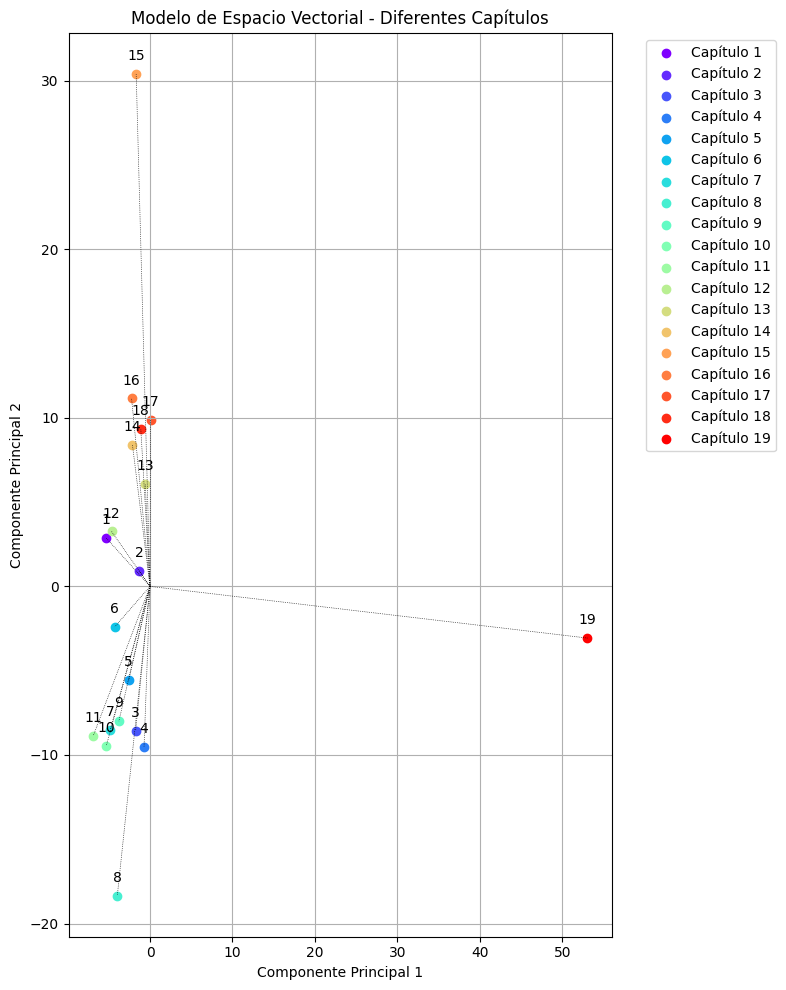

In [348]:
import os
import random
import glob
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

class TextRepresentation:
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.texts = self._load_texts()
        self.vocabulary = self._build_vocabulary()
        self.one_hot = self._one_hot_encoding()
        
    def _load_texts(self):
        if not os.path.exists(self.folder_path):
            raise Exception("The provided folder path does not exist.")
        files = sorted(glob.glob(os.path.join(self.folder_path, '*.txt')))
        texts = []
        for file in files:
            with open(file, 'r') as f:
                text = f.read()
                texts.append(text)
        return texts

    def _build_vocabulary(self):
        return set(' '.join(self.texts).split())

    def _one_hot_encoding(self):
        one_hot = []
        for text in self.texts:
            words = text.split()
            vector_text = [int(word in words) for word in self.vocabulary]
            one_hot.append(vector_text)
        return np.array(one_hot)

    def visualize_texts(self):
        pca = PCA(n_components=2)
        coordinates = pca.fit_transform(self.one_hot)
        
        plt.figure(figsize=(8, 10))
        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.texts)))
        for i, coord in enumerate(coordinates):
            plt.scatter(*coord, color=colors[i])
            plt.annotate(f"{i+1}", coord, textcoords="offset points", xytext=(0, 10), ha='center')
            plt.plot([0, coord[0]], [0, coord[1]], color='black', linestyle='dotted', linewidth=0.5)
            plt.scatter([], [], color=colors[i], label=f"Capítulo {i+1}")  # Plot vacío para generar la leyenda

        plt.xlabel('Componente Principal 1')
        plt.ylabel('Componente Principal 2')
        plt.title('Modelo de Espacio Vectorial - Diferentes Capítulos')
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()


text_rep = TextRepresentation('./capitulos')
text_rep.visualize_texts()



Para el resultado obtenido parece ser que se conforman tres tematicas entre los capitulos. Del capitulo 13 - 18 3 - 11 y otro con el 1, 2 y 12; por otro lado el capitulo 19 indica ser diferente al resto.

### Punto 12
Calcule el grado de similitud entre todos los documentos de su corpus empleando la medida de la distancia coseno (o medida de similitud coseno).


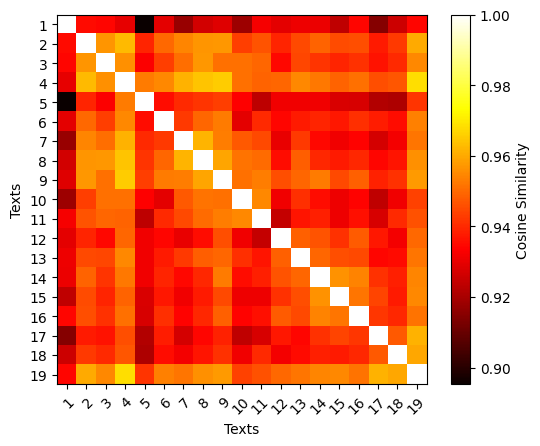

In [351]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

class TextSimilarity:
    def __init__(self, texts, vectorizer=TfidfVectorizer()):
        self.texts = texts
        self.vectorizer = vectorizer
        self.vectors = self._compute_vectors()
        self.similarity = self._compute_similarity()

    def _compute_vectors(self):
        return self.vectorizer.fit_transform(self.texts)

    def _compute_similarity(self):
        return cosine_similarity(self.vectors)

    def visualize_similarity(self):
        fig, ax = plt.subplots()
        im = ax.imshow(self.similarity, cmap='hot', interpolation='nearest')

        # Add a color bar
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.set_label('Cosine Similarity')

        # Show chapter numbers on x and y axes
        num_texts = len(self.texts)
        ax.set_xlabel('Texts')
        ax.set_ylabel('Texts')
        ax.set_xticks(np.arange(num_texts))
        ax.set_yticks(np.arange(num_texts))
        ax.set_xticklabels(np.arange(1, num_texts + 1))
        ax.set_yticklabels(np.arange(1, num_texts + 1))

        # Rotate x-axis labels for readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        plt.show()


# Use the class
similarity_analyzer = TextSimilarity(text_rep.texts)
similarity_analyzer.visualize_similarity()


### Cálculo de Similitud de Textos usando Distancia del Coseno

En este ejemplo, hemos aplicado el concepto de similitud del coseno para calcular la similitud entre varios documentos de texto en nuestro corpus. Para este fin, hemos creado una clase llamada `TextSimilarity`, que encapsula todo el proceso de cálculo de similitud y visualización.

### Clase TextSimilarity

Dentro de la clase `TextSimilarity`, se definen varias funciones:

- `__init__`: Este es el constructor de la clase, que inicializa la clase con los textos a analizar, y también configura el vectorizador a usar (en este caso, un vectorizador TF-IDF). El constructor también calcula los vectores TF-IDF y las similitudes de coseno para los textos.

- `_compute_vectors`: Esta función privada toma los textos y los convierte en vectores TF-IDF utilizando el vectorizador.

- `_compute_similarity`: Esta función privada toma los vectores TF-IDF y calcula las similitudes de coseno entre todos los pares de textos.

- `visualize_similarity`: Esta función visualiza la matriz de similitudes de coseno en un mapa de calor, con barras de colores correspondientes a los valores de similitud y los números de los textos en los ejes x e y.

### Uso de la clase

Para usar la clase, creamos una instancia de `TextSimilarity` pasando los textos a analizar. Luego, llamamos a `visualize_similarity` en la instancia para visualizar la matriz de similitud.

Finalmente, imprimimos la matriz de similitud de coseno para verificar los resultados. Cada fila y columna corresponde a un texto, y cada valor en la matriz representa la similitud del coseno entre esos dos textos. Los valores cercanos a 1 indican una alta similitud, mientras que los valores cercanos a 0 indican una baja similitud.

### Resultados

La matriz resultante muestra la similitud entre cada par de textos en el corpus. Los valores en la diagonal de la matriz son 1, ya que representan la similitud de un texto consigo mismo, que es máxima.

Por ejemplo, el valor en la posición (1,2) o (2,1) representa la similitud entre el primer y segundo texto, que es aproximadamente 0.935, lo que indica una alta similitud entre esos textos. De manera similar, se pueden interpretar otros valores en la matriz.

### Punto 13

Lleve su corpus a un espacio LSA. Conserve un numero reducido de dimensiones.

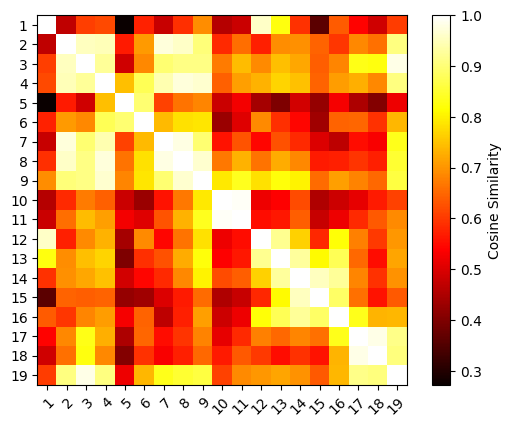

[[ 0.63116982  0.30852844 -0.2954956   0.29803489 -0.36066415  0.03520261]
 [ 0.75404739 -0.22862365  0.02458382 -0.10906498  0.00351112 -0.27819375]
 [ 0.70498765 -0.08297698  0.12324216 -0.05109034 -0.12328493 -0.15566132]
 [ 0.8013955  -0.18416522 -0.11170035 -0.05851953  0.0016032  -0.05686434]
 [ 0.60163592 -0.35827225 -0.27006624 -0.15129447  0.26852282  0.40611012]
 [ 0.68084546 -0.20251858 -0.31906442 -0.18822748 -0.05378333  0.25577809]
 [ 0.70779566 -0.35005194 -0.09718626 -0.03718886 -0.03696124 -0.26809781]
 [ 0.75992929 -0.27283377 -0.10644482  0.05931294 -0.0055325  -0.17366187]
 [ 0.76141216 -0.12577521 -0.05206654  0.1363789   0.02744752 -0.03999512]
 [ 0.65193955 -0.16172735  0.32799512  0.45177644  0.104266    0.1700921 ]
 [ 0.68903585 -0.18581027  0.30963518  0.37244424  0.06389507  0.1546162 ]
 [ 0.70952212  0.3210469  -0.25049403  0.16645153 -0.17399454  0.08567828]
 [ 0.70999871  0.32671607 -0.16682009  0.1276651   0.06430899 -0.13654665]
 [ 0.722854    0.29199871

In [358]:
class Preprocessing:
    def __init__(self, language='spanish', remove_punct=True, 
                 remove_stopwords=True, perform_stemming=True):
        self.language = language
        self.remove_punct = remove_punct
        self.remove_stopwords = remove_stopwords
        self.perform_stemming = perform_stemming

    def preprocess(self, text):
        if self.remove_punct:
            text = text.translate(str.maketrans("", "", string.punctuation))
        tokens = word_tokenize(text.lower())
        if self.remove_stopwords:
            stop_words = set(stopwords.words(self.language))
            tokens = [token for token in tokens if token not in stop_words]
        if self.perform_stemming:
            stemmer = SnowballStemmer(self.language)
            tokens = [stemmer.stem(token) for token in tokens]
        return ' '.join(tokens)

class TextSimilarity:
    def __init__(self, texts, vectorizer=TfidfVectorizer(), preprocessor=Preprocessing()):
        self.texts = texts
        self.vectorizer = vectorizer
        self.preprocessor = preprocessor
        self.preprocessed_texts = [preprocessor.preprocess(text) for text in texts]
        self.term_latent_matrix = self._compute_term_latent_matrix()

    def _compute_term_latent_matrix(self):
        tfidf_matrix = self.vectorizer.fit_transform(self.preprocessed_texts)
        lsa = TruncatedSVD(n_components=6)
        term_latent_matrix = lsa.fit_transform(tfidf_matrix)
        return term_latent_matrix.astype(float)

    def visualize_similarity(self):
        similarity = cosine_similarity(self.term_latent_matrix)
        fig, ax = plt.subplots()
        im = ax.imshow(similarity, cmap='hot', interpolation='nearest')

        # Add a color bar
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.set_label('Cosine Similarity')

        # Show text numbers on x and y axes
        num_texts = len(self.texts)
        ax.set_xticks(np.arange(num_texts))
        ax.set_yticks(np.arange(num_texts))
        ax.set_xticklabels(np.arange(1, num_texts + 1))
        ax.set_yticklabels(np.arange(1, num_texts + 1))

        # Rotate x-axis labels for readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        plt.show()


# Use the classes
similarity_analyzer = TextSimilarity(text_rep.texts)
similarity_analyzer.visualize_similarity()
print(similarity_analyzer.term_latent_matrix)



### Análisis de Similitud de Textos con LSA

Para analizar la similitud de varios textos, realizamos los siguientes pasos:

### Preprocesamiento

Antes de que los textos puedan ser analizados, necesitan ser preprocesados. El preprocesamiento incluye varios pasos para convertir el texto en una forma que pueda ser analizada de manera más eficaz. En este caso, los pasos son:

1. **Eliminar la puntuación:** Los signos de puntuación a menudo no contribuyen a la semántica del texto y pueden interferir con el análisis.

2. **Tokenizar:** Este paso divide el texto en palabras individuales, lo que permite que sean analizadas por separado.

3. **Eliminar palabras vacías:** Las palabras vacías (o stopwords) son palabras que se usan con frecuencia pero que no tienen mucho valor semántico, como "el", "la", "y", "de", etc. En muchos casos, estas palabras se eliminan para permitir un análisis más concentrado en las palabras que importan.

4. **Stemming:** Esta es la etapa de procesamiento que transforma las palabras a su raíz. Por ejemplo, las palabras "correr", "corrió" y "corriendo" se transformarían a su raíz común "corr".

Todos estos pasos están encapsulados en la clase `Preprocessing`.

### Vectorización

A continuación, el texto preprocesado se vectoriza. Esto significa que cada texto se convierte en un vector en un espacio multidimensional, donde cada dimensión corresponde a una palabra distinta del vocabulario. En este caso, se utiliza el método `TfidfVectorizer`, que significa "Frecuencia de término - Frecuencia inversa de documento". Este método asigna valores a las palabras basándose no solo en la frecuencia con la que aparecen en un documento, sino también en cuántos documentos aparecen.

### LSA

Luego, se realiza el Análisis Semántico Latente (LSA). LSA es un método para reducir la dimensionalidad de los datos. En este caso, se está reduciendo la dimensionalidad del espacio de palabras a un número más pequeño de "conceptos". En este ejemplo, se conservan solo 6 conceptos (especificado por `n_components=6`).

La matriz que se obtiene de este proceso (almacenada en `term_latent_matrix`) es una representación de cada texto en este espacio de conceptos reducidos.

### Visualización

Finalmente, calculamos la similitud de coseno entre cada par de textos en este espacio de conceptos y visualizamos estas similitudes en un mapa de calor.

La similitud del coseno es una métrica que determina la similitud entre dos vectores, y puede variar entre -1 y 1. Un valor más cercano a 1 implica que los textos son muy similares, mientras que un valor más cercano a -1 implica que son muy diferentes.

En el mapa de calor, cada celda en la intersección de la fila `i` y la columna `j` representa la similitud entre el texto `i` y el texto `j`.

### Resultado

El resultado impreso es la matriz de términos latentes (o matriz de conceptos) para cada texto. Cada fila representa un texto y cada columna representa un concepto. El valor en la intersección de la fila `i` y la columna `j` es la contribución del concepto `j` al texto `i`.

Estos valores se pueden interpretar como la importancia de cada concepto en cada texto. Por ejemplo, si el valor en la fila 1, columna 2 es alto, eso significa que el concepto 2 es importante para el texto 1.

### Punto 14
Implemente un clasificador no supervisado (p.ej.: k-means) que agrupe sus documentos en este espacio de representacion LSA.

/media/diego/Diego_Files/Personal_Projects/NLP-UTP/Taller2/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


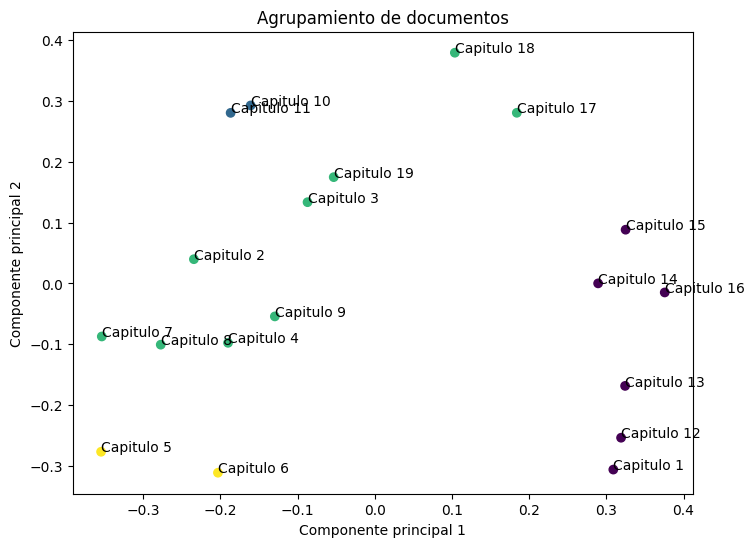

[[ 0.63116982  0.30858832 -0.29555983  0.29621488 -0.35743     0.03306943]
 [ 0.75404739 -0.22871792  0.02334396 -0.10710511 -0.0024065  -0.26924849]
 [ 0.70498766 -0.08302744  0.12284127 -0.0521831  -0.12215293 -0.15994672]
 [ 0.8013955  -0.18438872 -0.10982074 -0.05528274 -0.00392701 -0.05560279]
 [ 0.60163592 -0.35812012 -0.26940662 -0.15293367  0.27329046  0.39635835]
 [ 0.68084546 -0.20265898 -0.32032163 -0.18831681 -0.056515    0.26598243]
 [ 0.70779566 -0.3499892  -0.09771038 -0.03962775 -0.03329285 -0.26937703]
 [ 0.75992929 -0.27276187 -0.10569691  0.05953609 -0.00494643 -0.17421898]
 [ 0.76141216 -0.1256245  -0.05154608  0.13529047  0.03063871 -0.04082926]
 [ 0.65193955 -0.16161528  0.32868349  0.4543777   0.10210284  0.17684626]
 [ 0.68903585 -0.18598344  0.30804806  0.37057886  0.06555882  0.14791689]
 [ 0.70952212  0.32091887 -0.2504992   0.17002762 -0.18079907  0.08492642]
 [ 0.70999871  0.32681119 -0.16766258  0.12434419  0.06958319 -0.14025544]
 [ 0.722854    0.29190455

In [370]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

class TextSimilarity:
    def __init__(self, texts, vectorizer=TfidfVectorizer(), preprocessor=Preprocessing(), n_clusters=6):
        self.texts = texts
        self.vectorizer = vectorizer
        self.preprocessor = preprocessor
        self.n_clusters = n_clusters
        self.preprocessed_texts = [preprocessor.preprocess(text) for text in texts]
        self.term_latent_matrix = self._compute_term_latent_matrix()
        self.cluster_labels = self._compute_clusters()
        self.pca_result = self._compute_pca()

    def _compute_term_latent_matrix(self):
        tfidf_matrix = self.vectorizer.fit_transform(self.preprocessed_texts)
        lsa = TruncatedSVD(n_components=6)
        term_latent_matrix = lsa.fit_transform(tfidf_matrix)
        return term_latent_matrix.astype(float)

    def _compute_clusters(self):
        kmeans = KMeans(n_clusters=self.n_clusters)
        kmeans.fit(self.term_latent_matrix)
        return kmeans.labels_

    def _compute_pca(self):
        pca = PCA(n_components=2)
        return pca.fit_transform(self.term_latent_matrix)

    def visualize_similarity(self):
        similarity = cosine_similarity(self.term_latent_matrix)
        fig, ax = plt.subplots()
        im = ax.imshow(similarity, cmap='hot', interpolation='nearest')

        # Add a color bar
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.set_label('Cosine Similarity')

        # Show text numbers on x and y axes
        num_texts = len(self.texts)
        ax.set_xticks(np.arange(num_texts))
        ax.set_yticks(np.arange(num_texts))
        ax.set_xticklabels(np.arange(1, num_texts + 1))
        ax.set_yticklabels(np.arange(1, num_texts + 1))

        # Rotate x-axis labels for readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        plt.show()

    def visualize_clusters(self):
        plt.figure(figsize=(8, 6))
        plt.scatter(self.pca_result[:, 0], self.pca_result[:, 1], c=self.cluster_labels)
        names = [f"Capitulo {i+1}" for i in range(len(self.texts))]  # Etiquetas para los puntos
        for i, label in enumerate(names):
            plt.annotate(label, (self.pca_result[i, 0], self.pca_result[i, 1]))  # Agrega las etiquetas a cada punto
        plt.title('Agrupamiento de documentos')
        plt.xlabel('Componente principal 1')
        plt.ylabel('Componente principal 2')
        plt.show()

# Uso de las clases
similarity_analyzer = TextSimilarity(text_rep.texts, n_clusters=4)
similarity_analyzer.visualize_clusters()
print(similarity_analyzer.term_latent_matrix)


### Punto 15

Implemente un MDS (Multidimensional scaling) en su corpus original y compare los resultados con los obtenidos en el item anterior.

/media/diego/Diego_Files/Personal_Projects/NLP-UTP/Taller2/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/media/diego/Diego_Files/Personal_Projects/NLP-UTP/Taller2/.venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


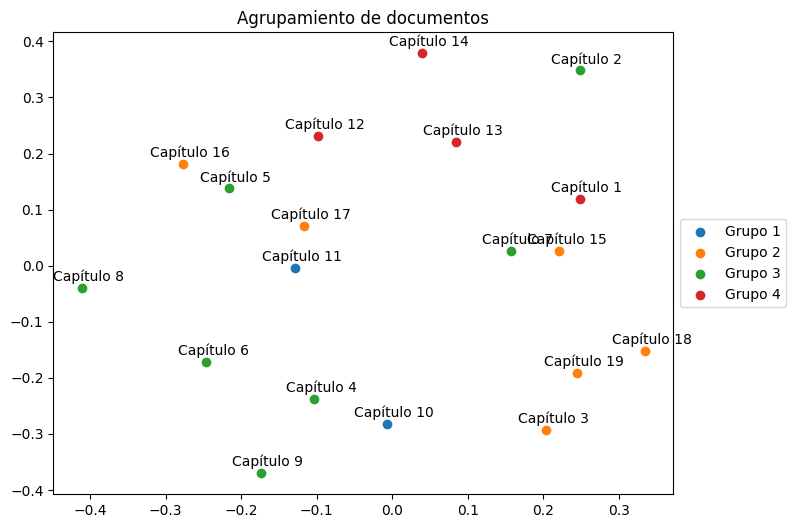

In [372]:
class TextCluster:
    def __init__(self, texts, vectorizer=TfidfVectorizer(), preprocessor=Preprocessing(), n_clusters=6):
        self.texts = texts
        self.vectorizer = vectorizer
        self.preprocessor = preprocessor
        self.n_clusters = n_clusters
        self.preprocessed_texts = [preprocessor.preprocess(text) for text in texts]
        self.X = self._vectorize_texts()

    def _vectorize_texts(self):
        return self.vectorizer.fit_transform(self.preprocessed_texts).toarray()

    def _calculate_similarity_matrix(self):
        return -np.array(self.X @ self.X.T)

    def _apply_dimensionality_reduction(self, matrix):
        mds = MDS(n_components=2, dissimilarity="precomputed")
        return mds.fit_transform(matrix)

    def _apply_clustering(self):
        return KMeans(n_clusters=self.n_clusters).fit(self.X)

    def visualize_clusters(self):
        clustering = self._apply_clustering()
        labels = clustering.labels_

        similarity_matrix = self._calculate_similarity_matrix()
        X_mds = self._apply_dimensionality_reduction(similarity_matrix)

        plt.figure(figsize=(8, 6))
        colors = plt.cm.tab10.colors  # Utilizar una paleta de colores predefinida
        for i, label in enumerate(set(labels)):
            indices = [j for j, x in enumerate(labels) if x == label]
            plt.scatter(X_mds[indices, 0], X_mds[indices, 1], color=colors[i % len(colors)], label=f'Grupo {label+1}')
        
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Ajustar la leyenda a la derecha
        # Etiquetas de los puntos
        for i, txt in enumerate(self.texts):
            plt.annotate(f'Capítulo {i+1}', (X_mds[i, 0], X_mds[i, 1]), textcoords="offset points", xytext=(5,5), ha='center')

        plt.title("Agrupamiento de documentos")
        plt.show()

# Uso de la clase
text_cluster = TextCluster(text_rep.texts, n_clusters=4)
text_cluster.visualize_clusters()
